In [1]:
import evspy
import evspy.loading_empirical_data as loading_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
class cs_model:
    def __init__(self, Calphahatc, Calphahats,  erateci, eratesi, Cc, Cr, CalphaNC, OCR_initial,OCR_final, sigma0 = 100, sigmap = 100,
                 dimt=100000,dtfactor=1e-7,Cv=5/3600/24/365,H=0.01,targettime=1e10, swelling_isotache = False,
                 nonlinear_Calphahat=False,sigmaref=100,beta2=4,beta3=19,hypA=False,
                model_type = 'load_controlled'):
        self.Calphahatc = Calphahatc
        self.Calphahats = Calphahats
        self.erateci = erateci
        self.eratesi = eratesi
        self.Cc = Cc
        self.Cr = Cr
        self.OCR_initial = OCR_initial
        self.OCR_final = OCR_final
        self.dimt = dimt
        self.dtfactor = dtfactor
        self.Cv = Cv
        self.H = H
        self.targettime = targettime
        self.nonlinear_Calphahat = nonlinear_Calphahat
        self.sigmaref = sigmaref
        self.beta2 = beta2
        self.beta3 = beta3
        self.hypA = hypA
        self.model_type = model_type
        self.g = 9.81
        self.sigma0 = sigma0
        self.swelling_isotache = swelling_isotache
        self.sigmap = sigmap
        
        if model_type == 'load_controlled':
            res = evspy.C_S_model_with_load(self.Calphahatc, self.Calphahats,  self.erateci, self.eratesi, self.Cr,self.Cc, 
                                        self.OCR_initial,self.OCR_final,dimt=self.dimt,dtfactor = self.dtfactor,Cv = self.Cv,H = self.H,targettime = self.targettime,
                                            nonlinear_Calphahat = self.nonlinear_Calphahat, sigmaref = self.sigmaref,beta2 = self.beta2,beta3 = self.beta3,hypA = self.hypA)
        elif model_type == 'relaxation':
            res = evspy.C_S_relaxation(self.Calphahatc, self.Calphahats,  self.erateci, self.eratesi, self.Cr,self.Cc,self.sigma0,dimt=self.dimt,dtfactor = self.dtfactor,
                                             targettime = self.targettime,nonlinear_Calphahat = self.nonlinear_Calphahat, swelling_isotache=self.swelling_isotache,
                                             OCR = self.OCR_final, beta2 = self.beta2, beta3 = self.beta3)
        elif model_type == 'rate_controlled':
            res = evspy.C_S_CRS(self.Cc,self.Cr,self.sigmap,self.erateci,self.CalphaNC,erateref = self.erateref, Cc_reduction=2.3,
                                Cc_f_OCR=False,erates0=-1,erate = 1,sigma0=265,sigmaf=160,b2=-5.5,m2=2.5,beta2=self.beta2,beta3=self.beta3,estart=1,m1=0.88,b1=-1.4,dtfactor=1)
            #### TO BE FINALISED!!!

        self.time = res['time']
        self.e = res['e']
        self.erate = res['erate']
        self.erate_c = res['erate_c']
        self.erate_s = res['erate_s']
        self.Calphahatc = res['Calphahatc']
        if model_type == 'load_controlled':
            self.OCR = res['OCR']
            self.OCR_ref = res['OCR_ref']
            self.erate_e = res['erate_e']
        if model_type == 'relaxation':
            self.sigma = res['sigma']
        


## Comments
- for UCFit2: if OCR_initial = 1.0: no swelling happening ==> SOLVED
- in case of high $\hat{C}_{\alpha,s}$, the effect of a non-linear Calpha becomes quite considerable; a smaller $\hat{C}_{\alpha,s}$ has much less effect ==> SOLVED
- the creep effect of the two models is very close to identical

## options to add:
- swelling: non-linear response under constant load; based on OCRref and based on OCR ==> what was used under CRS?
- creep: relation to OCRref vs eratec <=> swelling (CRS response?)
- example data to fit
- hypA properly during loading => SOLVED
- model_type = 'load_controlled'

# Unloading test

In [3]:
readings,metadata_readings,Cr_current,Cv_current,CalphaCc,testlist = loading_data.import_data()

In [5]:
tst = '/TA-1.49_.csv'
Calphahatc = 0.0015
Calphahats = 0.0005
erateci = 1e-8
eratesi = 1e-6
Cr = Cr_current[tst]
Cc = Cr*5
CalphaNC = Cc * 0.04
Cv = Cv_current[tst]
OCR_initial = 1.0
OCR_final = 1.5
model = {}
model[tst] = {}
model[tst][1] = cs_model(Calphahatc, Calphahats,  erateci, eratesi, Cc,Cr,CalphaNC, OCR_initial,OCR_final,Cv=Cv,nonlinear_Calphahat=True,hypA=False,beta2=4,beta3=20)
model[tst][2] = cs_model(Calphahatc, Calphahats,  erateci, eratesi, Cc,Cr,CalphaNC, OCR_initial,OCR_final,Cv=Cv,nonlinear_Calphahat=False,hypA=False,beta2=4,beta3=20)

/home/thomasvergote/anaconda3/envs/psgis/lib/python3.7/site-packages/evspy/creep_swelling_model.py:60: RuntimeWarning: invalid value encountered in log10
  erates[t-1]=erates[t-1]*10**(5*np.log10((OCR[t]-1)/(OCR[t-1]-1))) # Viscous swelling develops and reduces at the same time while unloading


Text(0, 0.5, 'Void ratio')

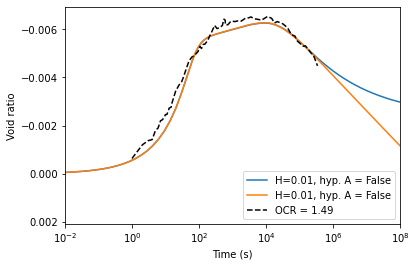

In [6]:
for tst in ['/TA-1.49_.csv']:
    for m in model[tst].values():
        plt.semilogx(m.time,m.e,label="H="+str(m.H)+', hyp. A = '+str(m.hypA))
    plt.plot(readings[tst]['time'],np.interp(readings[tst]['time'].iloc[1],m.time,m.e)+readings[tst]['void ratio change'],'k--',label='OCR = '+str(readings[tst]['OCR'].iloc[0]))

plt.plot()
plt.legend(loc=4)
plt.xlim(1e-2,1e8)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)'); plt.ylabel('Void ratio')

(1.0, 1.6)

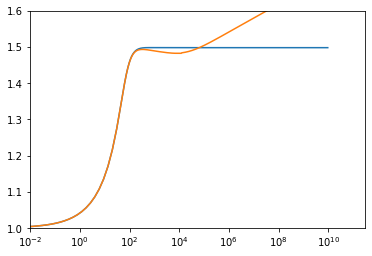

In [7]:
plt.semilogx(m.time,m.OCR)
plt.semilogx(m.time,m.OCR_ref)
plt.xlim(1e-2); plt.ylim(1,1.6)

# Loading test

In [8]:
OCR_initial = 1
OCR_final = 0.5
Cc = 0.3
Cr = Cc/5
Calphahatc = Cc*0.04
erateci = 1e-4
eratesi = 1e-40

In [9]:
model = {}
model[1] = cs_model(Calphahatc, Calphahats,  erateci, eratesi, Cr,Cc, OCR_initial,OCR_final,nonlinear_Calphahat=False,hypA=False,beta2=4,beta3=19)
model[2] = cs_model(Calphahatc, Calphahats,  erateci, eratesi, Cr,Cc, OCR_initial,OCR_final,nonlinear_Calphahat=False,hypA=True,beta2=4,beta3=19)
model[3] = cs_model(Calphahatc, Calphahats,  erateci, eratesi, Cr,Cc, OCR_initial,OCR_final,nonlinear_Calphahat=False,hypA=False,beta2=4,beta3=19, H = 0.5)
model[4] = cs_model(Calphahatc, Calphahats,  erateci, eratesi, Cr,Cc, OCR_initial,OCR_final,nonlinear_Calphahat=False,hypA=True,beta2=4,beta3=19, H = 0.5)

Text(0, 0.5, 'Void ratio')

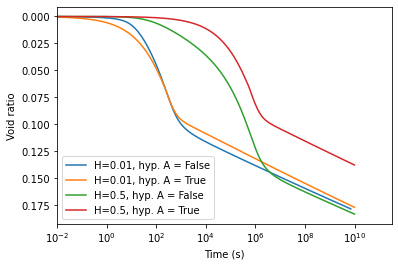

In [10]:
for m in model.values():
    plt.semilogx(m.time,m.e,label="H="+str(m.H)+', hyp. A = '+str(m.hypA))
plt.legend()
plt.xlim(1e-2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)'); plt.ylabel('Void ratio')

# Relaxation test

In [12]:
readings = {}
metadata_readings = {}
data_store = '../data/Empirical_data_vergote2020'
with pd.HDFStore(data_store) as hdf:
    test=hdf.keys()
    for tst in test:
        readings[tst], metadata_readings[tst] = loading_data.h5load(hdf,tst)

In [13]:
Calphahatc = 0.004
Calphahats = 0.004
erateci = 1e-7
eratesi = 1e-4
Cr = 0.24
Cc = 1.1
Cv = 1.58e-7
OCR_initial = 1.0
OCR_final = 1.2
sigma0=270
model = {}
model[1] = cs_model(Calphahatc, Calphahats,  erateci, eratesi, Cr,Cc, OCR_initial,OCR_final,sigma0=sigma0,nonlinear_Calphahat=True,hypA=False,beta2=4,beta3=19,model_type = 'relaxation')

Text(0, 0.5, 'Stress (kPa)')

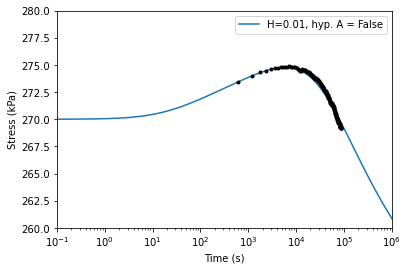

In [14]:
for m in model.values():
    plt.semilogx(m.time,m.sigma,label="H="+str(m.H)+', hyp. A = '+str(m.hypA))
tst = '/relaxation_OCR_1.21'
plt.semilogx(readings[tst]['time'],readings[tst]['load'],'k.')
plt.legend()
plt.xlim(1e-1,1e6)
plt.ylim(260,280)
plt.xlabel('Time (s)'); plt.ylabel('Stress (kPa)')

# CRS test

Text(0, 0.5, 'Void ratio change, $\\Delta e$')

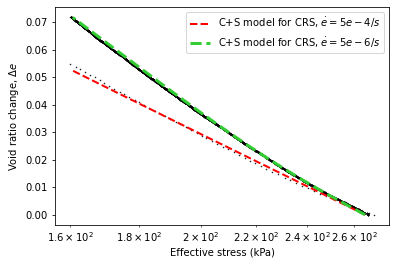

In [15]:
for tst in [ '/CRS_unloading_erate_-5e-6/s', '/CRS_unloading_erate_-5e-4/s']:
    plt.semilogx(readings[tst]['load'],readings[tst]['void_ratio']-readings[tst]['void_ratio'].iloc[0],'k.',ms=1)
m1=0.2
b1=-0.35 
m2=2.13
b2=-5.
sigmap=320
res=evspy.C_S_CRS(Cc,Cr=Cr,sigmap=sigmap,eratec0=1e-20,estart=0,erates0=-1,CalphaNC=0.066,m1=m1,b1=b1,erate=5e-4,m2=m2,b2=b2)
plt.plot(res['sigma'],res['e'],'r--',lw=2,label='C+S model for CRS, $\dot{e}=5e-4/s$')
res=evspy.C_S_CRS(Cc,Cr=Cr,sigmap=sigmap,eratec0=1e-20,estart=0,erates0=-1,CalphaNC=0.066,m1=m1,b1=b1,erate=5e-6,m2=m2,b2=b2)
plt.plot(res['sigma'],res['e'],'--',c='limegreen',lw=3,label='C+S model for CRS, $\dot{e}=5e-6/s$')
plt.legend()
plt.xlabel('Effective stress (kPa)')
plt.ylabel('Void ratio change, $\Delta e$')